# Import Libraries

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import sparse

# Load Data

In [41]:
link = "https://drive.google.com/file/d/12AQMi007QX_m5DqOdI-OFMwaxDz0SfTI/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (78298, 15)


# Data Preview and Info

In [42]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,Unnamed: 0,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0.0
1,1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0.0
2,2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0.0
3,3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0.0
4,4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0.0


In [43]:
# Train: select only the rows with labels
df_train = df[df["is_promoted"].notnull()].copy()

# Test: rows without labels
df_test = df[df["is_promoted"].isnull()].copy()
df_test.drop(columns="is_promoted", axis=1, inplace=True)
df_test = df_test.reset_index(drop=True)

# Quick shape check
print("Train shape:", df_train.shape)
print("\nTest shape:", df_test.shape)

df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nTrain Data Info:")
df_train.info()

print("\nTest Data Info:")
df_test.info()

Train shape: (54808, 15)

Test shape: (23490, 14)

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 54808 entries, 0 to 54807
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            54808 non-null  int64  
 1   employee_id           54808 non-null  int64  
 2   department            54808 non-null  object 
 3   region                54808 non-null  object 
 4   education             52399 non-null  object 
 5   gender                54808 non-null  object 
 6   recruitment_channel   54808 non-null  object 
 7   no_of_trainings       54808 non-null  int64  
 8   age                   54808 non-null  int64  
 9   previous_year_rating  50684 non-null  float64
 10  length_of_service     54808 non-null  int64  
 11  KPIs_met >80%         54808 non-null  int64  
 12  awards_won?           54808 non-null  int64  
 13  avg_training_score    54808 non-null  int64  
 14  is_prom

## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **training dataset** contains 54808 samples with 15 columns, including the target variable `is_promoted`.
   - The **test dataset** includes 23490 samples with 14 columns (without the target), ready for prediction.

**Feature Overview**  
   - Both datasets include all important attributes:  
     - **Numerical features:** `age`, `length_of_service`, `avg_training_score`.
     - **Categorical features:** `department`, `region`, `education`, `gender`, `recruitment_channel`, `KPIs_met >80%`, `awards_won?`, `previous_year_rating`, `no_of_trainings`.
   - The target variable is categorical (only train data).

**Data Consistency and Completeness**  
   - The datasets have **missing values** across datasets.
   - Data types are appropriate: numerical features are float64 and int64, and categorical features are objects (strings).
   - The column `Unnamed: 0` is not meaningful for analysis. So this column is not really a part of the information we should care about. We can drop this column for both train and test data.

In [44]:
# Remove 'Unnamed: 0' column
df_train.drop(columns="Unnamed: 0", axis = 1, inplace=True)
df_test.drop(columns="Unnamed: 0", axis = 1, inplace=True)

In [45]:
def label_no_of_training(row):
  if row["no_of_trainings"] == 1:
    return "trained once"
  elif row["no_of_trainings"] == 2:
    return "trained twice"
  elif row["no_of_trainings"] == 3:
    return "trained three times"
  else:
    return "trained more than 3 times"

df_train["no_of_trainings"] = df_train.apply(label_no_of_training, axis=1)
df_test["no_of_trainings"] = df_test.apply(label_no_of_training, axis=1)

In [46]:
num_features = ["age", "length_of_service", "avg_training_score"]
cat_features = ["department", "region", "education", "gender", "recruitment_channel", "KPIs_met >80%", "awards_won?", "previous_year_rating", "no_of_trainings"]
target_feature = "is_promoted"
list_features_drop_train = ["department", "region", "education", "gender", "recruitment_channel", "KPIs_met >80%", "awards_won?", "previous_year_rating", "no_of_trainings", "is_promoted", "employee_id"]
list_features_drop_test = ["department", "region", "education", "gender", "recruitment_channel", "KPIs_met >80%", "awards_won?", "previous_year_rating", "no_of_trainings", "employee_id"]

print("Train Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df_train.drop(columns=list_features_drop_train, axis=1).describe().T.style.background_gradient(cmap=cm))

print("\nTest Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df_test.drop(columns=list_features_drop_test, axis=1).describe().T.style.background_gradient(cmap=cm))

Train Data describe:


,count,mean,std,min,25%,50%,75%,max
age,54808.000000,34.803915,7.660169,20.000000,29.000000,33.000000,39.000000,60.000000
length_of_service,54808.000000,5.865512,4.265094,1.000000,3.000000,5.000000,7.000000,37.000000
avg_training_score,54808.000000,63.386750,13.371559,39.000000,51.000000,60.000000,76.000000,99.000000



Test Data describe:


,count,mean,std,min,25%,50%,75%,max
age,23490.000000,34.782929,7.679492,20.000000,29.000000,33.000000,39.000000,60.000000
length_of_service,23490.000000,5.810387,4.207917,1.000000,3.000000,5.000000,7.000000,34.000000
avg_training_score,23490.000000,63.263133,13.411750,39.000000,51.000000,60.000000,76.000000,99.000000


## Descriptive Insights – Numerical Features

* Employees are mainly in the **middle-age group (30–40 years old)**.
* **Average tenure is relatively short** (\~6 years), with most employees below 10 years of service.
* **Training performance is generally good**, though there is a clear gap between average performers (\~60) and high performers (>75).

**The training and test datasets show very similar distributions across numerical features, ensuring consistency between them.**

In [47]:
def convert_cat(features, df = df):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
convert_cat(cat_features, df=df_train)
convert_cat(cat_features, df=df_test)

df_train["age"] = df_train["age"].astype("int8")
df_train["avg_training_score"] = df_train["avg_training_score"].astype("int8")
df_train["length_of_service"] = df_train["length_of_service"].astype("int8")
df_train["is_promoted"] = df_train["is_promoted"].astype("int8")

df_test["age"] = df_test["age"].astype("int8")
df_test["avg_training_score"] = df_test["avg_training_score"].astype("int8")
df_test["length_of_service"] = df_test["length_of_service"].astype("int8")

# Display information about the DataFrames
print("\nTrain Data Info:")
df_train.info()

print("\nTest Data Info:")
df_test.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   employee_id           54808 non-null  int64   
 1   department            54808 non-null  category
 2   region                54808 non-null  category
 3   education             52399 non-null  category
 4   gender                54808 non-null  category
 5   recruitment_channel   54808 non-null  category
 6   no_of_trainings       54808 non-null  category
 7   age                   54808 non-null  int8    
 8   previous_year_rating  50684 non-null  category
 9   length_of_service     54808 non-null  int8    
 10  KPIs_met >80%         54808 non-null  category
 11  awards_won?           54808 non-null  category
 12  avg_training_score    54808 non-null  int8    
 13  is_promoted           54808 non-null  int8    
dtypes: category(9), int64(1), int8(4)
memory 

In [48]:
list_features_drop_train = ["age", "length_of_service", "avg_training_score", "is_promoted", "employee_id"]
list_features_drop_test = ["age", "length_of_service", "avg_training_score", "employee_id"]

print("Train Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df_train.drop(columns=list_features_drop_train, axis=1).describe().T.style.background_gradient(cmap=cm, subset=["unique", "freq"]))

print("\nTest Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df_test.drop(columns=list_features_drop_test, axis=1).describe().T.style.background_gradient(cmap=cm, subset=["unique", "freq"]))

Train Data describe:


,count,unique,top,freq
department,54808,9,Sales & Marketing,16840
region,54808,34,region_2,12343
education,52399,3,Bachelor's,36669
gender,54808,2,m,38496
recruitment_channel,54808,3,other,30446
no_of_trainings,54808,4,trained once,44378
previous_year_rating,50684.000000,5.000000,3.000000,18618.000000
KPIs_met >80%,54808,2,0,35517
awards_won?,54808,2,0,53538



Test Data describe:


,count,unique,top,freq
department,23490,9,Sales & Marketing,7315
region,23490,34,region_2,5299
education,22456,3,Bachelor's,15578
gender,23490,2,m,16596
recruitment_channel,23490,3,other,13078
no_of_trainings,23490,4,trained once,18928
previous_year_rating,21678.000000,5.000000,3.000000,7921.000000
KPIs_met >80%,23490,2,0,15061
awards_won?,23490,2,0,22955


## Descriptive Insights from Dataset Statistics

* **Department:** There are 9 departments, with **Sales & Marketing** being the most frequent in both train (16,840) and test (7,315).
* **Region:** Contains 34 regions, with **region\_2** appearing the most.
* **Education:** The majority of employees hold a **Bachelor’s degree**.
* **Gender:** The proportion of **male (m)** employees is higher, consistent in both train and test.
* **Recruitment Channel:** Three channels, with **other** being the most common.
* **No. of Trainings:** Most employees have **attended training once**.
* **Previous Year Rating:** Scale of 1–5, mode = **3**, with a similar distribution across train and test.
* **KPIs\_met >80%:** Most employees **did not meet KPI >80% (value = 0)**.
* **Awards\_won?:** The majority of employees **did not receive an award (value = 0)**.

**General Remarks**

* Train and test datasets have **very similar distributions**, ensuring consistency for model training and prediction.
* Some features are highly imbalanced, e.g., `awards_won?`, `KPIs_met >80%`, and `no_of_trainings`, where most values are concentrated in a single category.

# Data Quality Checks

## Missing Value

In [49]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value train dataset: ")
displayNULL(df_train, dataset_name="Train Set")

print("\nMissing value test dataset: ")
displayNULL(df_test, dataset_name="Test Set")

Missing value train dataset: 
🔎 Missing Value Summary for: Train Set
+----------------------+---------------+-----------+
| Feature              | Missing_Count | Missing_% |
+----------------------+---------------+-----------+
| previous_year_rating | 4124          | 7.52      |
| education            | 2409          | 4.4       |
+----------------------+---------------+-----------+

⚠️  Total missing values: 6,533 out of 54,808 rows.

Missing value test dataset: 
🔎 Missing Value Summary for: Test Set
+----------------------+---------------+-----------+
| Feature              | Missing_Count | Missing_% |
+----------------------+---------------+-----------+
| previous_year_rating | 1812          | 7.71      |
| education            | 1034          | 4.4       |
+----------------------+---------------+-----------+

⚠️  Total missing values: 2,846 out of 23,490 rows.


## Checking duplicate Value

In [50]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Training Data": df_train,
    "Test Data": df_test
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }
    print()

🔍 Training Data Duplicate Analysis
✅ No duplicates found in 54,808 rows

🔍 Test Data Duplicate Analysis
✅ No duplicates found in 23,490 rows



## Checking Outlier Value

In [51]:
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []
    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        if len(outliers) == 0:
            pass
        else:
            outlier_info.append({
            "Feature": feature,
            "Outlier Count": len(outliers),
            # "Outlier Detail": outliers.tolist()
            })
    return pd.DataFrame(outlier_info)

checking_outlier(list_feature=num_features, df=df_train, dataset_name="Training data")

🔍 Training data Checking outlier


,Feature,Outlier Count
0,age,1435
1,length_of_service,3489


In [52]:
checking_outlier(list_feature=num_features, df=df_test, dataset_name="Test data")

🔍 Test data Checking outlier


,Feature,Outlier Count
0,age,627
1,length_of_service,1485


### Data Quality Insights: Missing Values, Duplicates and Outliers.

**Missing Values Analysis**

* We conducted a thorough examination for missing values across the **train** and **test** datasets.

* **Training and Test Data**:

  * Missing values were found in **2 features**:

    * `previous_year_rating`: 4124 missing (**7.52%**) - train data and 1812 missing (**7.71%**) - test data.
    * `education`: 2409 missing (**4.4%**) - train data and 1034 missing (**4.4%**) - test data.

**Duplicate Records Analysis**

* We performed a check for exact duplicate rows that could artificially inflate performance or introduce bias.

* **Train and Test Data**:

  * **0 duplicate rows** found.

**Outlier Analysis**

* We also examined the datasets for checking outliers.
* **The outliers** were found in dataset at features. But we can not remove them since these outliers reflect reality.
* Both **train**, **origin** and **test** datasets contain **notable outliers** in `age` and `person_income`.

**Conclusion**

* The pattern of missing values is consistent across the training and test datasets.
* The **synthetic training** and **test datasets** exhibit excellent data quality with **duplicate entries**.
* The outlier value exist across the **train** and **test** datasets.

# Promoted Distribution

In [53]:
def color(n_colors=2):
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    positions = np.linspace(0, 1, n_colors)
    colors = [cmap(p) for p in positions]
    return colors

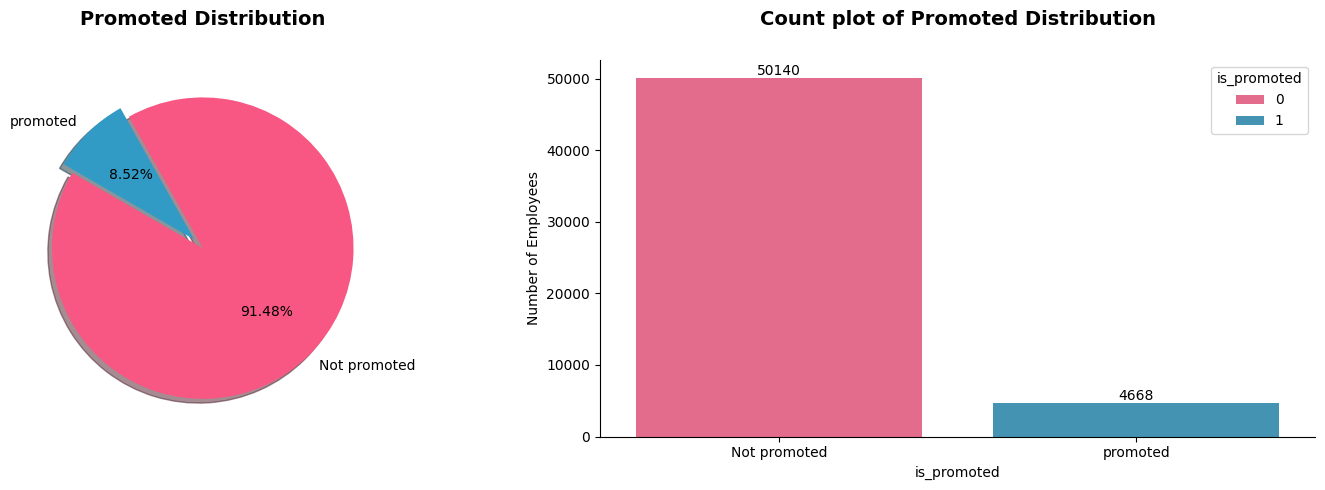

In [54]:
promoted_distribution  = df_train["is_promoted"].value_counts()
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15, 5))
n_color = color(n_colors=df_train["is_promoted"].nunique())
# ax[0]
ax[0].pie(
    promoted_distribution,
    labels = ["Not promoted", "promoted"],
    colors = n_color,
    autopct = "%1.2f%%",
    startangle = 150,
    explode = (0, 0.08),
    shadow= True
)
ax[0].set_title("Promoted Distribution",  weight="bold", fontsize=14, pad=25)

# ax[1]
sns.countplot(data=df_train, x = "is_promoted", palette=n_color, hue="is_promoted",
              ax=ax[1])
ax[1].set_title("Count plot of Promoted Distribution", weight="bold", fontsize=14, pad=25)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%d", label_type="edge", fontsize=10)
ax[1].set_ylabel("Number of Employees")
ax[1].set_xticks([0, 1], ["Not promoted", "promoted"])
ax[1].set_xlabel("is_promoted")
sns.despine(ax=ax[1], top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()

### Insights into Promotion Distribution

**Frequency of promotion categories**

* The pie chart and count plot show the distribution of promotion labels.
* `Not promoted` employees dominate with **50,140 records**, accounting for approximately **91.48%** of the dataset.
* `Promoted` employees are relatively rare, with only **4,668 records**, making up just **8.52%** of the dataset.

***The dataset is highly imbalanced, with non-promoted employees vastly outnumbering promoted ones. This imbalance poses a significant challenge for promotion prediction modeling, as models may become biased toward predicting the majority (not promoted) class. Techniques such as resampling (SMOTE, undersampling), ensemble methods, or cost-sensitive learning will be necessary to improve the detection of the minority promoted cases.***

# Data Pre-processing

In [55]:
X = df_train.drop("is_promoted", axis=1)
y = df_train["is_promoted"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [56]:
list_feature_num_robust = ["age", "length_of_service"]
list_feature_num_stand = ["avg_training_score"]
list_feature_cat_onehot = ["department", "region", "education", "gender", "recruitment_channel", "KPIs_met >80%", "awards_won?", "previous_year_rating", "no_of_trainings"]

# Currently, the features age and length_of_service contain outliers, so we will use RobustScaler to scale them in order to reduce the impact of these outliers.
num_robust_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

num_stand_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Handling Text and Categorical Attributes
])

In [57]:
preprocessor = ColumnTransformer(transformers=[
    ("num_robust", num_robust_transformer, list_feature_num_robust),
    ("num_standard", num_stand_transformer, list_feature_num_stand),
    ("cat_onehot", cat_onehot_transformer, list_feature_cat_onehot)
])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_robust',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['age', 'length_of_service']),
                                ('num_standard',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['avg_training_score']),
                                ('cat_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['department', 'region', 'education', 'gender',
                                  'recruitment_channel', 'KPIs_met >80%',
                                  'awards_won?', 'previous_year_rating',
                                  'no_of_trainings'])])

In [58]:
X_train_prepared = preprocessor.transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_robust__age',
 'num_robust__length_of_service',
 'num_standard__avg_training_score',
 'cat_onehot__department_Analytics',
 'cat_onehot__department_Finance',
 'cat_onehot__department_HR',
 'cat_onehot__department_Legal',
 'cat_onehot__department_Operations',
 'cat_onehot__department_Procurement',
 'cat_onehot__department_R&D',
 'cat_onehot__department_Sales & Marketing',
 'cat_onehot__department_Technology',
 'cat_onehot__region_region_1',
 'cat_onehot__region_region_10',
 'cat_onehot__region_region_11',
 'cat_onehot__region_region_12',
 'cat_onehot__region_region_13',
 'cat_onehot__region_region_14',
 'cat_onehot__region_region_15',
 'cat_onehot__region_region_16',
 'cat_onehot__region_region_17',
 'cat_onehot__region_region_18',
 'cat_onehot__region_region_19',
 'cat_onehot__region_region_2',
 'cat_onehot__region_region_20',
 'cat_onehot__region_region_21',
 'cat_onehot__region_region_22',
 'cat_onehot__region_region_23',
 'cat_onehot__region_region_24',
 'cat_onehot__region_reg

In [59]:
Xt = X_train_prepared.toarray() if sparse.issparse(X_train_prepared) else X_train_prepared
df_train_prepared = pd.DataFrame(Xt, columns=list_feature_prepared)
display(df_train_prepared.head())

,num_robust__age,num_robust__length_of_service,num_standard__avg_training_score,cat_onehot__department_Analytics,cat_onehot__department_Finance,cat_onehot__department_HR,cat_onehot__department_Legal,cat_onehot__department_Operations,cat_onehot__department_Procurement,cat_onehot__department_R&D,...,cat_onehot__awards_won?_1,cat_onehot__previous_year_rating_1.0,cat_onehot__previous_year_rating_2.0,cat_onehot__previous_year_rating_3.0,cat_onehot__previous_year_rating_4.0,cat_onehot__previous_year_rating_5.0,cat_onehot__no_of_trainings_trained more than 3 times,cat_onehot__no_of_trainings_trained once,cat_onehot__no_of_trainings_trained three times,cat_onehot__no_of_trainings_trained twice
0,-0.2,0.00,-1.150578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.1,-0.25,1.095756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.4,-0.25,1.020878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.1,2.50,-1.225456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.2,0.25,1.694779,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [60]:
Xt_val = X_val_prepared.toarray() if sparse.issparse(X_val_prepared) else X_val_prepared
df_val_prepared = pd.DataFrame(Xt_val, columns=list_feature_prepared)
display(df_val_prepared.head())

,num_robust__age,num_robust__length_of_service,num_standard__avg_training_score,cat_onehot__department_Analytics,cat_onehot__department_Finance,cat_onehot__department_HR,cat_onehot__department_Legal,cat_onehot__department_Operations,cat_onehot__department_Procurement,cat_onehot__department_R&D,...,cat_onehot__awards_won?_1,cat_onehot__previous_year_rating_1.0,cat_onehot__previous_year_rating_2.0,cat_onehot__previous_year_rating_3.0,cat_onehot__previous_year_rating_4.0,cat_onehot__previous_year_rating_5.0,cat_onehot__no_of_trainings_trained more than 3 times,cat_onehot__no_of_trainings_trained once,cat_onehot__no_of_trainings_trained three times,cat_onehot__no_of_trainings_trained twice
0,0.2,1.25,-1.225456,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,-0.25,-0.925945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.5,1.50,0.047467,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.75,-0.551556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.4,-0.25,1.245512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


> We will use **X\_train\_prepared** and **X\_val\_prepared** as inputs for the model instead of **df\_train\_prepared** and **df\_val\_prepared**. The purpose of creating these two variables is solely for displaying the dataframes.